# Preamble

Import necessary packages and setup logging.

In [1]:
from dolfin import *
import numpy as np

import sys
sys.path.append( "./hippylib" )
from hippylib import *

import logging

import matplotlib.pyplot as plt
sys.path.append( "./hippylib/tutorial" )
import nb

logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)
set_log_active(False)

from collections import deque

# Setup Function Spaces


In [2]:
# TODO: Pick the spaces carefully
nx = 200
ny = 200
mesh = UnitSquareMesh(nx, ny)
Vs = FunctionSpace(mesh, 'Lagrange', 2)
Vu = FunctionSpace(mesh, 'Lagrange', 2)

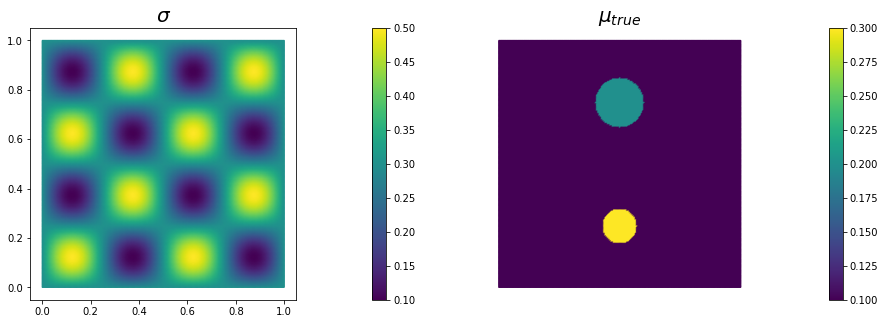

In [3]:
# TODO: Initialize these to the right values
# The true and inverted parameter
sigma_true = interpolate(Expression('0.3 + 0.2 * sin(4 * pi * x[0]) * sin(4 * pi * x[1])', degree=5),Vs)
#sigma = interpolate(Expression('0.3 + 0.2 * sin(4 * pi * x[0]) * sin(4 * pi * x[1])', degree=2),Vs)
sigma = interpolate(Expression('0.3', degree=2),Vs)

#TODO: Change this to come from the proper space (mu \in H1(\Omega))
mu_true = interpolate(Expression('0.1 + 0.1*(pow(pow(x[0] - 0.5,2) + pow(x[1] - 0.75,2),0.5) < 0.1) + 0.2*(pow(pow(x[0] - 0.5,2) + pow(x[1] - 0.25,2),0.5) < 0.07)', degree=5),Vs)
mu = interpolate(Expression('0.1 + 0.1*(pow(pow(x[0] - 0.5,2) + pow(x[1] - 0.75,2),0.5) < 0.1) + 0.2*(pow(pow(x[0] - 0.5,2) + pow(x[1] - 0.25,2),0.5) < 0.07)', degree=5),Vs)

# define function for state and adjoint
u = Function(Vu)
v = Function(Vu)

# define Trial and Test Functions
u_trial, v_trial, sigma_trial, mu_trial = TrialFunction(Vu), TrialFunction(Vu), TrialFunction(Vs), TrialFunction(Vs)
u_test, v_test, sigma_test, mu_test = TestFunction(Vu), TestFunction(Vu), TestFunction(Vs), TestFunction(Vs)

# Gruneisen coefficient
Gamma = Constant("1.0")

# diffusion coefficient
gamma = interpolate(Expression('0.03 + 0.01 * sin(2 * pi * x[1])', degree=3), Vs)

# true solution
u_true = Function(Vu)

#Important constants
kappa = 0.4  # Regularization constant
J = 4 #No. of data sets

plt.figure(figsize=(15,5))
nb.plot(sigma_true, subplot_loc=121, mytitle=r"$\sigma$", show_axis='on')
nb.plot(mu_true, subplot_loc=122, mytitle=r"$\mu_{true}$")
plt.show()

## Set up boundary conditions
The semilinear equation has given boundary values whereas the linear equation has homogeneous boundary conditions.

In [4]:
# TODO: bc with g defined by problem
# set up dirichlet boundary conditions
def boundary(x,on_boundary):
    return on_boundary


bcs_state = []
bcs_adj = []


for i in range(0,J):
    g = Constant(1.0 + i * 0.05)
    bc_state = DirichletBC(Vu, g, boundary)
    bcs_state.append(bc_state)
    bc_adj = DirichletBC(Vu, Constant(0.), boundary)
    bcs_adj.append(bc_adj)


## Setting up synthetic observations

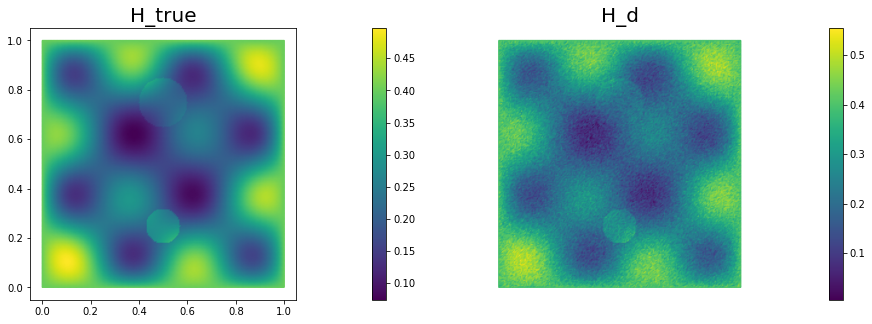

In [5]:
# Set the level of noise:
noise_level = 0.05

H_datas = []

for in in range(0,J):
    F_true = inner(gamma * nabla_grad(u_true), nabla_grad(u_test)) * dx + \
        sigma_true * u_true * u_test * dx + \
        mu_true * abs(u_true) * u_true * u_test * dx

    solve(F_true == 0, u_true, bcs = bc_state, solver_parameters={"newton_solver":{"relative_tolerance":1e-6}})

    H_data = project(Gamma * sigma_true * u_true + Gamma * mu_true * u_true * abs(u_true), Vu)


    # TODO: Proper noise addition as per paper
    MAX = H_data.vector().norm("linf")
    noise = u_true.vector().copy()
    noise.set_local( noise_level * MAX * np.random.normal(0, 1, len(H_data.vector().array())) )
    bc_adj.apply(noise)
    H_data.vector().axpy(1., noise)
    H_datas.append(H_data)

#nb.plot(H_data, subplot_loc=122, mytitle="H_d")
#plt.show()

## Setting up the objective functional

In [6]:
def mismatch_cost(Gamma, sigma, mu, u_s, Hs):
    mismatch_cost_i = 0
    for i in range(0,J):
        mismatch = Gamma * sigma * u_s[i] + Gamma * mu * abs(u_s[i]) * u_s[i] - Hs[i]
        mismatch_cost_i += assemble(inner(mismatch, mismatch) * dx) 
    return 0.5 * mismatch_cost_i

def regularization_cost(k, sigma, mu):
    reg_sigma = assemble(inner(grad(sigma),grad(sigma)) * dx)
    reg_mu = assemble(inner(grad(mu),grad(mu)) * dx) 
    return kappa * 0.5 * reg_sigma

def cost(Gamma, sigma, mu, u_s, H_datas, k):
    return mismatch_cost(Gamma, sigma, mu, u_s, H_datas) + regularization_cost(kappa, sigma, mu)

0.04228906353459474


## BFGS 

cost: 0.002568956548160377


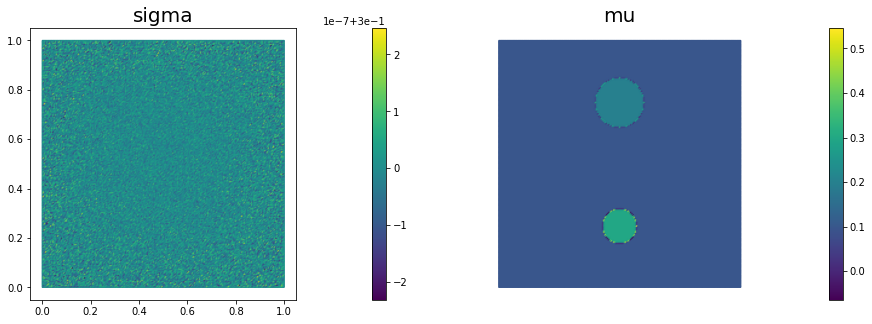

obj_d_sigma norm: 0.0004716722045855078
obj_d_mu norm: 6.317234103117056
cost: 0.00256692530203701


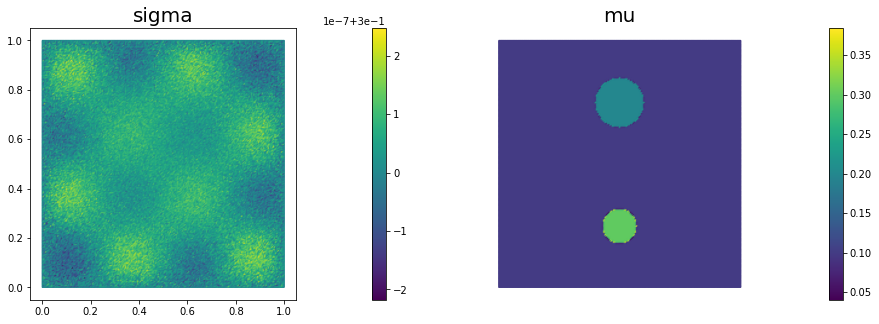

obj_d_sigma norm: 0.00040451931993565733
obj_d_mu norm: 6.110912036030129
cost: 0.0025668921918448563


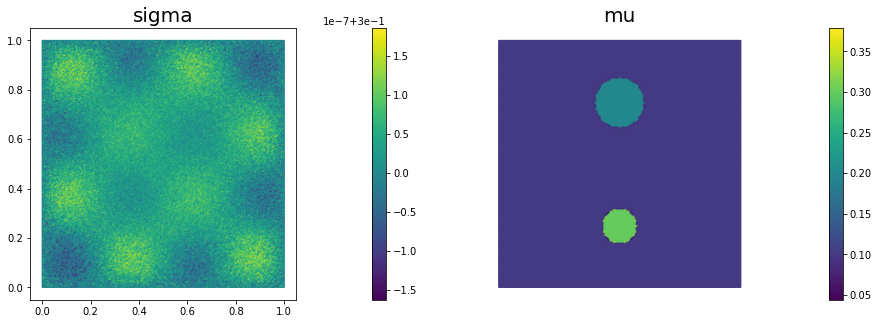

obj_d_sigma norm: 0.00038508575968477214
obj_d_mu norm: 0.9382541150917844
cost: 0.0025671189002678947


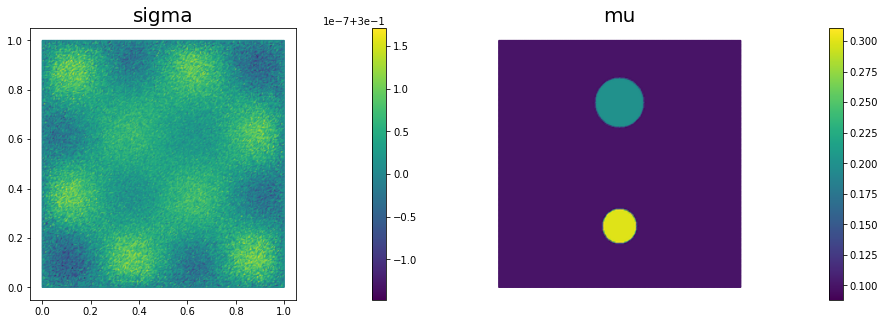

obj_d_sigma norm: 0.00036675613574074843
obj_d_mu norm: 12.469950403040343
cost: 0.0025899046497831315


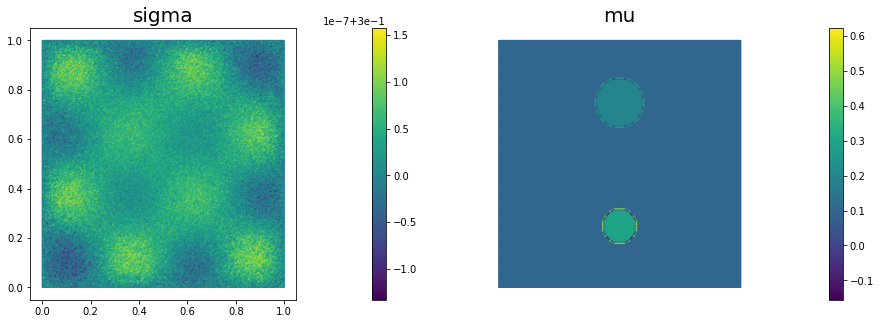

obj_d_sigma norm: 0.0003493807175093944
obj_d_mu norm: 3.7200805481070525
cost: 0.0025669533016866074


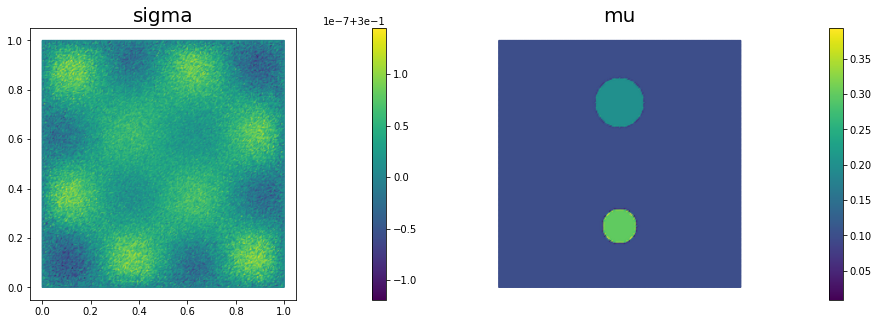

obj_d_sigma norm: 0.00033302493301409704
obj_d_mu norm: 1.3500492506100812
cost: 0.0025688738942954144


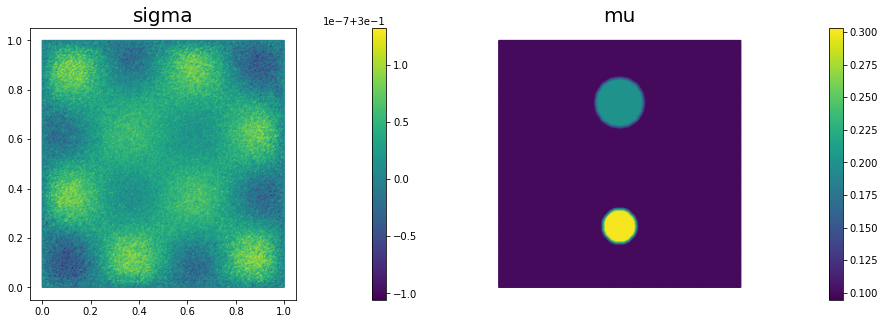

obj_d_sigma norm: 0.00031775321931502474
obj_d_mu norm: 1.8509311644602715
cost: 0.0025687940879413423


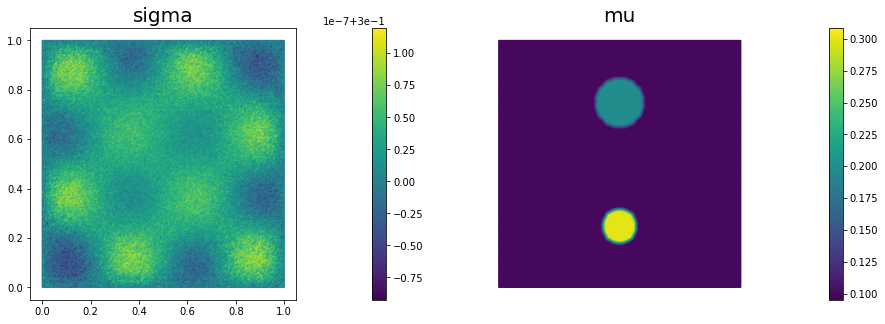

obj_d_sigma norm: 0.0004961717120758122
obj_d_mu norm: 0.45522609274027426
cost: 0.0025686327186375904


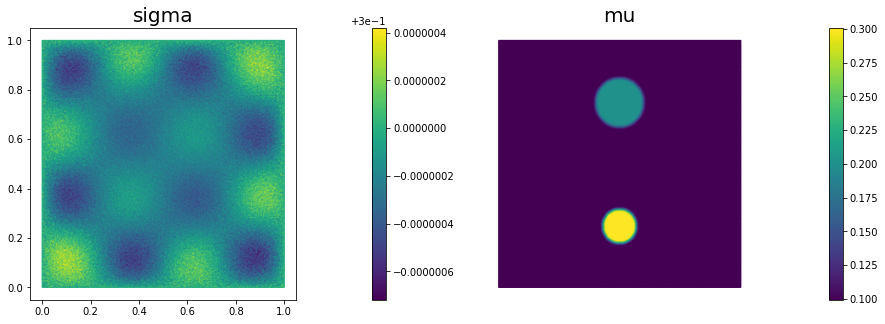

obj_d_sigma norm: 0.0004986582494590203
obj_d_mu norm: 0.44905706348930413
cost: 0.002568627755775574


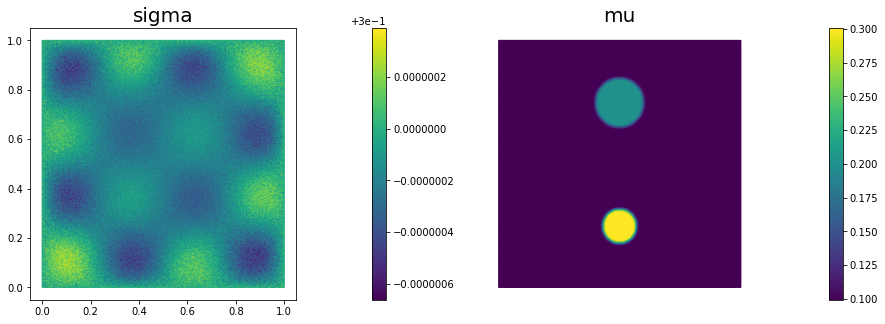

obj_d_sigma norm: 0.0004997691439519435
obj_d_mu norm: 0.25019495430659444
cost: 0.0025685484291879303


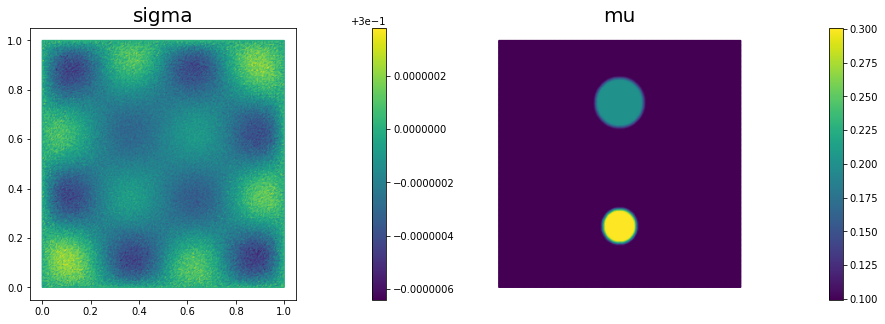

obj_d_sigma norm: 0.0005007925154425495
obj_d_mu norm: 0.24596816645219566
cost: 0.0025685528882431986


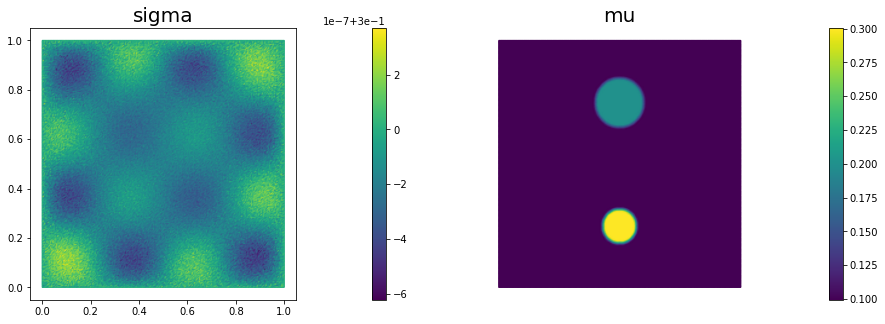

obj_d_sigma norm: 0.0005018199474546946
obj_d_mu norm: 0.2418480203235608
cost: 0.0025685606830613476


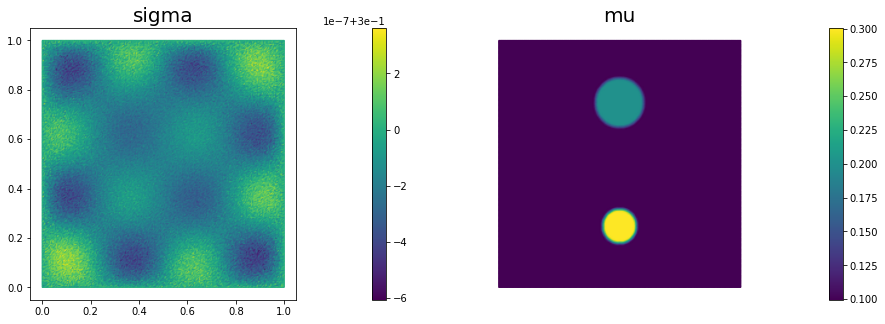

obj_d_sigma norm: 0.0005028546448254155
obj_d_mu norm: 0.23783131252288242
cost: 0.0025685692125355093


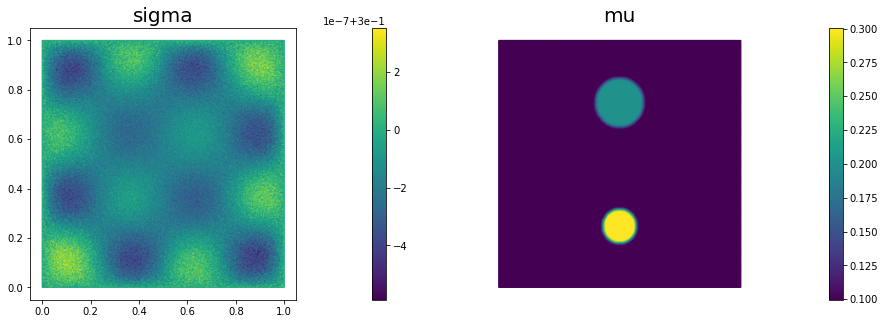

obj_d_sigma norm: 0.000503900684736662
obj_d_mu norm: 0.23406169170900368
cost: 0.0025685746500773727


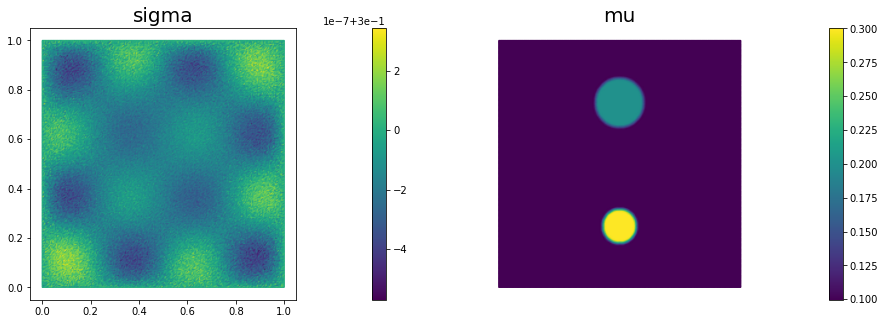

obj_d_sigma norm: 0.0004952132037168962
obj_d_mu norm: 0.2441103978625678
cost: 0.0025685810066545128


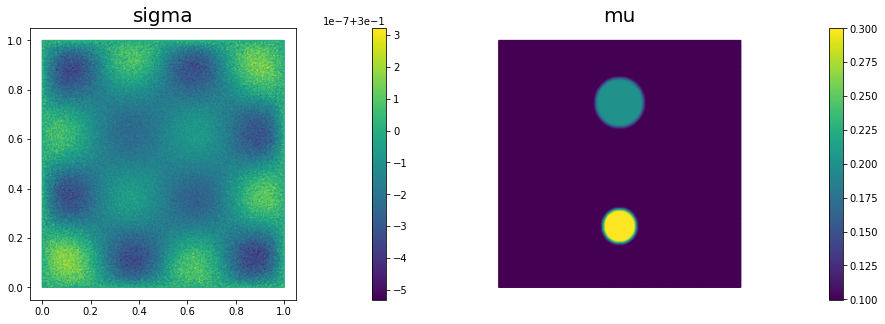

obj_d_sigma norm: 0.000495736287825748
obj_d_mu norm: 0.24219655577751076
cost: 0.002568586162439148


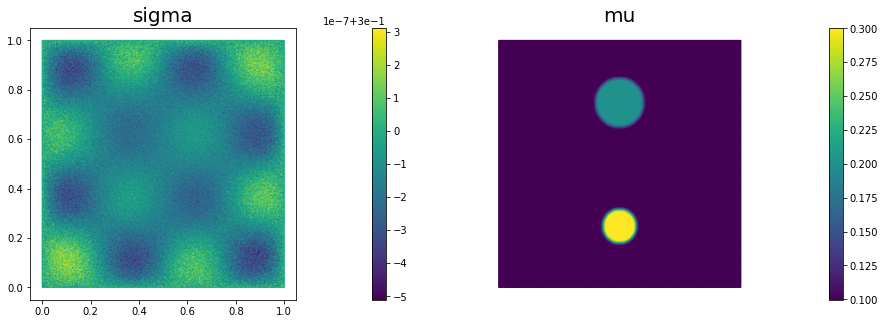

obj_d_sigma norm: 0.0004961516119792339
obj_d_mu norm: 0.23991698522006444
cost: 0.002568586611112959


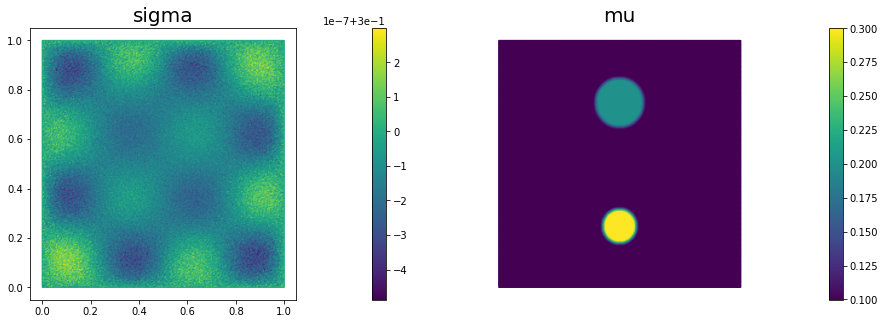

obj_d_sigma norm: 0.0004964713074091845
obj_d_mu norm: 0.23937465853952566
cost: 0.0025685879703131217


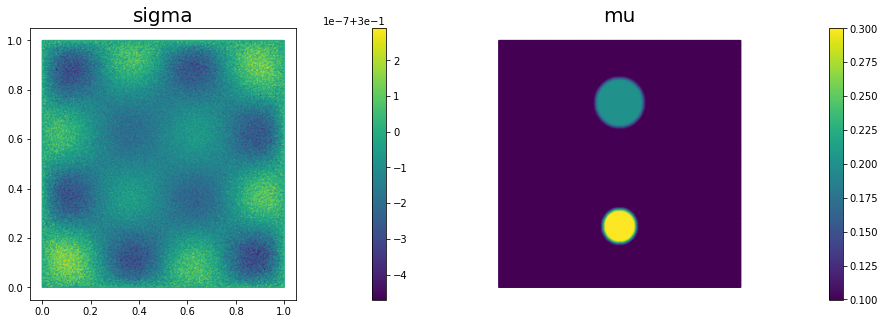

obj_d_sigma norm: 0.0004968065848567459
obj_d_mu norm: 0.24025682346462318
cost: 0.002568587638451966


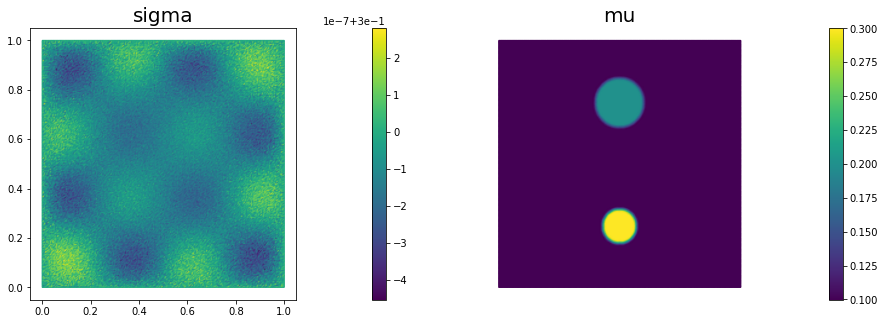

obj_d_sigma norm: 0.0004971511152854764
obj_d_mu norm: 0.258766242216886
cost: 0.0025685946434798263
Converged


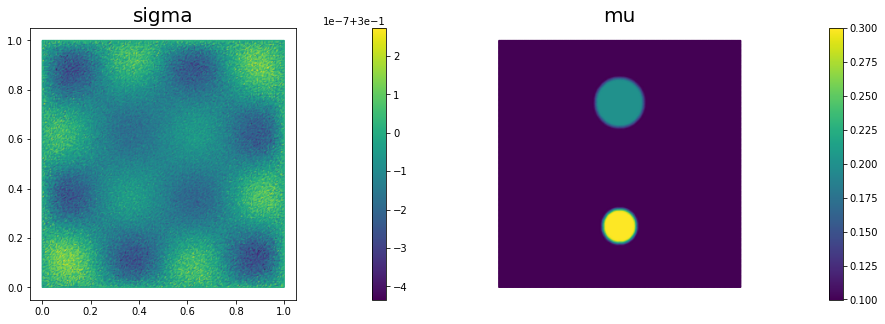

In [7]:
def linesearch(f, g, x_0, d, f_x_0, g_x_0):
    '''
    Performs a linesearch satisfying the Wolfe conditions
    in the direction of d
    
    Refer to Algorithm 3.5 in
    Wright, J., & Nocedal, J. (2006). Numerical Optimization (2nd Edition)
    for more information.
    
    Args:
        f:     Objective function as a function of x
        g:     Gradient of the objective function as a function of x
        x_0:   Initial function argument vector
        d:     Search direction
        f_x_0: Objective functional value at x_0, i.e: f(x_0) 
        g_x_0: Objective functional gradient value at x_0, i.e: f'(x_0) (in the direction of d)

    Returns:
        alpha: Step size 

    Raises:
        
    '''
    
    def zoom(alpha_lo, alpha_hi):
        k = 0
        zoom_MAX = 4
        while True:
            #print ("Zoom iteration: {}, alpha_hi: {}, alpha_lo: {}".format(k, alpha_hi, alpha_lo))
            alpha_j = 0.5*(alpha_lo + alpha_hi)
            f_j = f(x_0 + alpha_j * d)
            f_lo = f(x_0 + alpha_lo * d)
            
            if (f_j > f_x_0 + c_1 * alpha_j * g_x_0) or (f_j >= f_lo):
                alpha_hi = alpha_j
            else:
                g_j = d.inner(g(x_0 + alpha_j * d))
                if abs(g_j) <= -c_2 * g_x_0:
                    return alpha_j
                if g_j * (alpha_hi - alpha_lo) >= 0:
                    alpha_hi = alpha_lo
                alpha_lo = alpha_j
            k += 1
            if k > zoom_MAX:
                return alpha_j
    
    c_1 = 1e-4
    c_2 = 0.9
    alpha_MAX = 20.0
    alpha_i = 1.0
    alpha_prev = 0.0
    f_i_p = f_x_0
    i = 1
    
    while True:
        #print ("Iteration: {}, alpha: {}".format(i,alpha_i))
        f_i = f(x_0 + alpha_i * d)
        
        if (f_i > f_x_0 + c_1 * alpha_i * g_x_0) or (i > 1 and f_i > f_i_p):
            return zoom(alpha_prev, alpha_i)
        
        g_i = d.inner(g(x_0 + alpha_i * d))
        
        if abs(g_i) <= -c_2 * g_x_0:
            return alpha_i
        
        if g_i >= 0:
            return zoom(alpha_i, alpha_prev)
        
        alpha_prev = alpha_i
        r = 0.8 #TODO: Examine this heuristic
        alpha_i = alpha_prev + alpha_prev * r
        f_i_p = f_i
        i += 1
        
        if alpha_i > alpha_MAX:
            return alpha_i

def gradient(gamma, sigma, mu, Gamma, u_s, v_s):
    '''
    Computes the gradient of the objective function with respect
    to sigma and mu
    '''
    obj_d_sigma = 0 * dx
    obj_d_mu = 0 * dx
    
    for i in range(0, J):
        u = u_s[i]
        v = v_s[i]
        
        # semilinear forward equation to obtain u
        forward_eq = inner(gamma * nabla_grad(u), nabla_grad(u_test)) * dx + \
            sigma * u * u_test * dx + \
            mu * abs(u) * u * u_test * dx

        solve(forward_eq == 0, u, bcs = bc_state)

        z = Gamma * (sigma * u + mu * abs(u) * u) - H_data

        # linear adjoint equation to obtain v
        adjoint_eq_bilinear = inner(gamma * nabla_grad(v_trial), nabla_grad(v_test)) * dx + \
            (sigma + 2 * mu * abs(u)) * v_trial * v_test * dx

        adjoint_eq_L = -z * Gamma * sigma * v_test * dx + 2 * mu * abs(u) * v_test * dx

        solve(adjoint_eq_bilinear == adjoint_eq_L, v, bc_adj)

        # use u and v obtain gradients of the objective function w.r.t. sigma and mu
        obj_d_sigma += z * Gamma * u * sigma_test * dx + v * u * sigma_test * dx   
        obj_d_mu += z * Gamma * abs(u) * u * mu_test *  dx + v * abs(u) * u * mu_test * dx  
            
    obj_d_sigma += inner(kappa * nabla_grad(sigma), nabla_grad(sigma_test)) * dx
    obj_d_mu += inner(kappa * nabla_grad(mu), nabla_grad(mu_test)) * dx
        
    return assemble(obj_d_sigma), assemble(obj_d_mu)


def L_BFGS(sigma, mu):
    '''
    Limited memory BFGS quasi-Newton method implementation used to 
    solve the minimization problem arising from the least squares reconstruction method.
    For more information about the limited-memory BFGS method, refer to 
    Wright, J., & Nocedal, J. (2006). Numerical Optimization (2nd Edition)
    '''
    def cost_sigma(s_vec):
        s = Function(Vs)
        s.vector().set_local(s_vec.array()[:])
        return cost(Gamma, s, mu, u, H_data, k)
    def grad_sigma(s_vec):
        s = Function(Vs)
        s.vector().set_local(s_vec.array()[:])
        return gradient(gamma, s, mu, Gamma, u, v)[0]
    def cost_mu(m_vec):
        m = Function(Vs)
        m.vector().set_local(m_vec.array()[:])
        return cost(Gamma, sigma, m, u, H_data, k)
    def grad_mu(m_vec):
        m = Function(Vs)
        m.vector().set_local(m_vec.array()[:])
        return gradient(gamma, sigma, m, Gamma, u, v)[1]
    
    k = 0
    m_MAX = 7
    m = 1
    s_sigma = deque()
    s_mu = deque()
    y_sigma = deque()
    y_mu = deque()
    rho_sigma = deque()
    rho_mu = deque()
    alpha_sigma = [0] * m_MAX
    alpha_mu = [0] * m_MAX
    converged = False
    
    # Take a single step
    q_sigma, q_mu = gradient(gamma, sigma, mu, Gamma, u_s, v_s)
    c = cost(Gamma, sigma, mu, u_s, H_datas, k)
    
    a_sigma = linesearch(cost_sigma, grad_sigma, sigma.vector(), -q_sigma, c, q_sigma.inner(q_sigma))
    a_mu = linesearch(cost_mu, grad_mu, mu.vector(), -q_mu, c, q_mu.inner(q_mu))
    
    sigma.vector()[:] = sigma.vector()[:] - a_sigma * q_sigma
    mu.vector()[:] = mu.vector()[:] - a_mu * q_mu
    
    s_sigma.append(-a_sigma * q_sigma)
    s_mu.append(-a_mu * q_mu)
    
    q_sigma_prev = q_sigma
    q_mu_prev = q_mu
    
    q_sigma, q_mu = gradient(gamma, sigma, mu, Gamma, u_s, v_s)
    
    y_sigma.append(q_sigma - q_sigma_prev)
    y_mu.append(q_mu - q_mu_prev)
    rho_sigma.append(1.0/y_sigma[-1].inner(s_sigma[-1]))
    rho_mu.append(1.0/y_mu[-1].inner(s_mu[-1]))

    while not converged:
        # TODO: Conditions for convergence
        
        c = cost(Gamma, sigma, mu, u_s, H_datas, k)
        print ("cost: {}".format(c))

        if c < 1e-5 or k == 20:
            if c < 1e1:
                print ("Converged")
            else:
                print ("Maximum iterations reached")
            converged = True
            break
        
        plt.figure(figsize=(15,5))
        nb.plot(sigma, subplot_loc=121, mytitle="sigma", show_axis='on')
        nb.plot(mu, subplot_loc=122, mytitle="mu")
        plt.show()

        for i in range(0,m):
            alpha_sigma[i] = rho_sigma[i] *  s_sigma[i].inner(q_sigma)
            q_sigma = q_sigma - alpha_sigma[i] * y_sigma[i]
            alpha_mu[i] = rho_mu[i] *  s_mu[i].inner(q_mu)
            q_mu = q_mu - alpha_mu[i] * y_mu[i]
                
        gamma_k_sigma = s_sigma[-1].inner(y_sigma[-1])/y_sigma[-1].inner(y_sigma[-1])
        r_sigma = gamma_k_sigma * q_sigma
    
        gamma_k_mu = s_mu[-1].inner(y_mu[-1])/y_mu[-1].inner(y_mu[-1])
        r_mu = gamma_k_mu * q_mu

        for i in range(m-1,-1,-1):
            # Iterate backwards
            beta_sigma = rho_sigma[i] * y_sigma[i].inner(r_sigma)
            r_sigma = r_sigma + s_sigma[i]*(alpha_sigma[i] - beta_sigma)  
            beta_mu = rho_mu[i] * y_mu[i].inner(r_mu)
            r_mu = r_mu + s_mu[i]*(alpha_mu[i] - beta_mu)  

        p_sigma_k = -r_sigma
        p_mu_k = -r_mu

        # TODO: Satisfy Wolfe conditions for a
        a_sigma = linesearch(cost_sigma, grad_sigma, sigma.vector(), p_sigma_k, c, q_sigma.inner(p_sigma_k))
        a_mu = linesearch(cost_mu, grad_mu, mu.vector(), p_mu_k, c, q_mu.inner(p_mu_k))

        sigma.vector()[:] = sigma.vector()[:] + a_sigma * p_sigma_k
        mu.vector()[:] = mu.vector()[:] + a_mu * p_mu_k

        k += 1
        if m < m_MAX:
            m += 1

        s_sigma.append(a_sigma * p_sigma_k)
        s_mu.append(a_mu * p_mu_k)

        q_sigma_prev = q_sigma
        q_mu_prev = q_mu
        q_sigma, q_mu = gradient(gamma, sigma, mu, Gamma, u, v)
        
        print ("obj_d_sigma norm: {}".format(norm(q_sigma)))
        print ("obj_d_mu norm: {}".format(norm(q_mu)))

        y_sigma.append(q_sigma - q_sigma_prev)
        y_mu.append(q_mu - q_mu_prev)

        rho_sigma.append(1.0/y_sigma[-1].inner(s_sigma[-1]))
        rho_mu.append(1.0/y_mu[-1].inner(s_mu[-1]))

        if k >= m_MAX:
            s_sigma.popleft()
            s_mu.popleft()
            y_sigma.popleft()
            y_mu.popleft()
            rho_sigma.popleft()
            rho_mu.popleft()
            

L_BFGS(sigma, mu)

plt.figure(figsize=(15,5))
nb.plot(sigma, subplot_loc=121, mytitle="sigma", show_axis='on')
nb.plot(mu, subplot_loc=122, mytitle="mu")
plt.show()